# t-SNE

In [1]:
%reset -f
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import sys
sys.path.insert(0,'..')
from wavhandler import *
import numpy as np
import sys
import math
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from utils_train import train_test_val_split, TrainConfiguration, train_generator, valid_generator,mosquito_data_split, train_model_dl
from utils_train import n_cpus
from configs import *
import matplotlib.pyplot as plt
import seaborn as sns
import os
seed = 42
np.random.seed(seed=seed)

In [2]:
splitting = 'random'
cust = 'na' # 4
data_setting = 'raw'
model_setting = 'dl4tsc_inc'
layer_name = 'dense'#'global_average_pooling1d'#'dense'#

assert splitting in ['random','randomcv','custom'], "Wrong splitting method given."
assert data_setting in ['raw','stft','psd_dB'], "Wrong data settting given."
assert model_setting in ['wavenet','lstm','gru','conv1d','conv1d_psd',
                        'DenseNet121','DenseNet169','DenseNet201',
                        'InceptionResNetV2','VGG16','VGG19',
                        'dl4tsc_fcn','dl4tsc_res', 'tsc_res_baseline',
                        'tsc_fcn_baseline', 'conv1d_baseline', 'dl4tsc_inc'], "Wrong model setting given"

data = Dataset('Wingbeats')
print(data.target_classes)

print(f'SPLITTING DATA {splitting}')
X_train, X_val, X_test, y_train, y_val, y_test = mosquito_data_split(splitting=splitting, dataset=data)
if splitting == 'custom':
    X_train = X_train[cust]
    X_val = X_val[cust]
    y_train = y_train[cust]
    y_val = y_val[cust]

['Ae. aegypti', 'Ae. albopictus', 'An. arabiensis', 'An. gambiae', 'C. pipiens', 'C. quinquefasciatus']
SPLITTING DATA random
Species: Ae. aegypti.
Read 85553 filenames in 1.51 seconds.
Species: Ae. albopictus.
Read 20231 filenames in 1.47 seconds.
Species: An. arabiensis.
Read 19297 filenames in 1.52 seconds.
Species: An. gambiae.
Read 49471 filenames in 1.56 seconds.
Species: C. pipiens.
Read 30415 filenames in 1.54 seconds.
Species: C. quinquefasciatus.
Read 74599 filenames in 1.56 seconds.


In [3]:
from configs import ModelConfiguration, TrainConfiguration

traincf = TrainConfiguration(dataset=data, 
                             setting=data_setting,
                             batch_size=64,
                             model_name=f'../temp_data/{splitting}_{data_setting}_{model_setting}_ss')

In [4]:
config = ModelConfiguration(model_setting=model_setting, 
                            data_setting=data_setting, 
                            target_names=traincf.target_names)
model = config.config

############ INPUT SHAPE:(5000, 1)
/home/kalfasyan/projects/wingbeat_frequencies/temp_data/


In [5]:

# model.get_layer(layer_name)
layer_name = layer_name+'_1'
model.load_weights(f'../temp_data/results/dl/{splitting}_{data_setting}_{model_setting}_{cust}.h5')

In [6]:
from tensorflow.keras.models import Model


model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [7]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

In [8]:
from utils_train import calculate_train_statistics
train_stats = calculate_train_statistics(X_train=X_train, setting=data_setting)

features = model.predict_generator(valid_generator(X_test, y_test, 
                                                  batch_size=traincf.batch_size, 
                                                  setting=traincf.setting, 
                                                  target_names=traincf.target_names,
                                                  preprocessing_train_stats=train_stats),
                                  steps = int(math.ceil(float(len(X_test)) / float(traincf.batch_size))),
                                  max_queue_size=20, workers=1)

In [9]:

# sns.set_style("white")

params = {"learning_rate": [10],#,100,200],#,500,1000],
          "perplexity": [20,30,50,100,150],
          "init": ['pca'], #,'random'],
          "steps": [1000]}#, 5000]}  

for lr in params["learning_rate"]:
    for px in params["perplexity"]:
        for ini in params["init"]:
            for st in params["steps"]:
                fname = f'/home/kalfasyan/projects/wingbeat_frequencies/temp_data/logs/{splitting}_{data_setting}_{model_setting}{cust}_{layer_name}_init{ini}_lr{lr}_px{px}_steps{st}.png'
                print(f'Learning rate: {lr}\nPerplexity: {px}\nInit: {ini}\nSteps: {st}\n')
                if not os.path.isfile(fname):
                    tSNE = TSNE(learning_rate=lr, 
                                perplexity=px, 
                                init=ini, 
                                random_state=0, 
                                n_iter=st, 
                                n_jobs=-1)
                    X_final = tSNE.fit_transform(features)

                    plt.figure(figsize=(20,12))
                    sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.9, legend='full', 
                                    hue=y_test,
                                    palette=sns.color_palette("cubehelix", 6))

                
                    plt.savefig(fname, format='png', bbox_inches = 'tight', pad_inches = 0)
                    plt.close()

Learning rate: 10
Perplexity: 20
Init: pca
Steps: 1000

Learning rate: 10
Perplexity: 30
Init: pca
Steps: 1000

Learning rate: 10
Perplexity: 50
Init: pca
Steps: 1000

Learning rate: 10
Perplexity: 100
Init: pca
Steps: 1000

Learning rate: 10
Perplexity: 150
Init: pca
Steps: 1000



In [9]:
fname = f'/home/kalfasyan/projects/wingbeat_frequencies/temp_data/logs/{splitting}_{data_setting}_{model_setting}{cust}_{layer_name}'

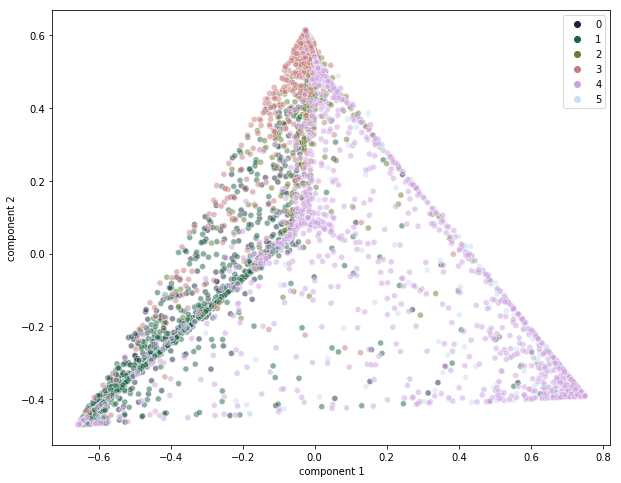

In [10]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler(with_std=False).fit_transform(features)  # standardization of data

pca = PCA(n_components=2)

X_final = pca.fit_transform(X_std)

plt.figure(figsize=(10,8))
sns.scatterplot(X_final[:,0], X_final[:,1],
                alpha=0.5, 
                legend='full', 
                hue=y_test, 
                palette=sns.color_palette("cubehelix", 6)) 
plt.xlabel('component 1')
plt.ylabel('component 2')
pcaname = f'{fname[:-4]}_pca.png'
plt.savefig(pcaname, format='png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

plt.close()

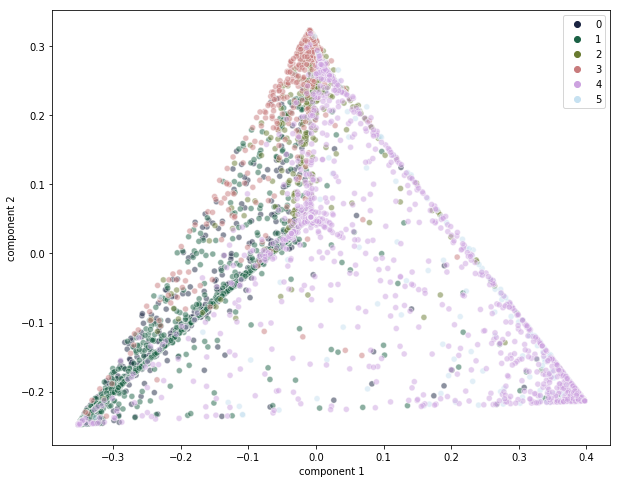

In [11]:
from sklearn.decomposition import KernelPCA

X_std = StandardScaler(with_std=False).fit_transform(features)  # standardization of data

rbf_pca = KernelPCA(n_components=2, kernel="rbf")

X_final = rbf_pca.fit_transform(X_std)

plt.figure(figsize=(10,8))
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.5, legend='full', 
                hue=y_test,
                palette=sns.color_palette("cubehelix", 6)) 
plt.xlabel('component 1')
plt.ylabel('component 2')

kpcaname = f'{fname[:-4]}_kpca.png'
plt.savefig(kpcaname, format='png')
plt.show()

plt.close()

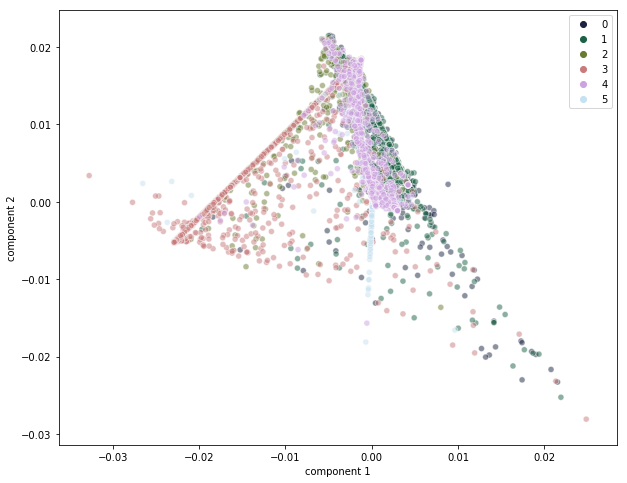

In [12]:
from sklearn.manifold import LocallyLinearEmbedding

X_std = StandardScaler(with_std=False).fit_transform(features)  # standardization of data

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=13)
X_final = lle.fit_transform(X_std)

plt.figure(figsize=(10,8))
sns.scatterplot(X_final[:,0], X_final[:,1],alpha=0.5, legend='full', 
                hue=y_test,
                palette=sns.color_palette("cubehelix", 6)) 
plt.xlabel('component 1')
plt.ylabel('component 2')

llename = f'{fname[:-4]}_lle.png'
plt.savefig(llename, format='png', bbox_inches = 'tight', pad_inches = 0)
plt.show()

plt.close()

In [13]:
X_final.shape

(12000, 2)